# CUBIC vs. Tahoe

In [my last blog post](http://www.squidarth.com/rc/programming/networking/2018/07/18/intro-congestion.html), I introduce the concept of congestion control and the Tahoe congestion control scheme.

In this notebook, I introduce a new algorithm: [CUBIC](https://tools.ietf.org/html/rfc8312), and evaluate its performance.

CUBIC is currently the default algorithm used in Linux, and implementations have existed since 2004.

### What are the problems with Tahoe?


To recap some of the concepts in congestion control--the main thing that congestion control algorithms control is is the **congestion window**, which is the number of packets that the congestion control algorithm will keep in flight at any given point in time. The optimal congestion window to have is the amount of packets that will fit on the particular link you are sending on, which is the BDP (Bandwidth-delay product, computed as the product of the delay on a network with the bandwidth).

Tahoe was devised in 1988, and since then, a lot has changed on the internet. Notably, there are much more high BDP links than there were back then. To fully take advantage of these high BDP links, senders need to send with a much higher congestion window.

As I discuss in the last blog post, once Tahoe has crossed the "slow start threshold", it begins to grow the size of the congestion window linearly. While this is fine on low BDP links, on higher BDP links, it takes longer to converge, and will end up not performing optimally.

### Introducing: CUBIC

In order to perform better on these high bandwidth links, we need to solve two main problems:

1. Growing the congestion window faster so that we can take more advantage of the bandwidth
2. Back off on growing the window as quickly to not be unfair to traditional TCP algorithms

From these two problems, it seems like we'd want to have a multi-phase algorithm that alternately probes for more
bandwidth, and then once the available bandwidth has been discovered, grows slowly up to that discovered bandwidth.

It turns out that there is a function that satisfies this "multi-phase" requirement, the cubic function!

![cubic function](cubic_function.png)

The rough sketch of the CUBIC congestion control algorithm is that it has a "concave" phase (before the inflection point), and a "convex" phase (after the inflection point).

It starts out by growing the congestion window quickly,
slows down around a value called `w_max`. The window grows very slowly around `w_max`, and if no packet loss happens, it starts growing quickly in order to probe for more bandwidth. Once packet loss is experienced, `w_max`
is set to be the window size when the loss happened.

In each of these experiments, I print out the throughput of the algorithm, along with graphs of the link queue size
over time, the RTTs over time, and the congestion window over time.

### Getting set up with this notebook:

All of the code for this project is at this repo.

I've only tested this on Ubuntu--if you are using MacOS or another operating system, I highly suggest using Vagrant to spin up a VM.

```bash
$ sudo apt-get update
$ sudo apt-get install mahimahi python-pip -y
$ sudo apt-get install python3-pip
$ pip3 install -r requirements.txt

$ # This needs to run every time you restart the computer
$ sudo sysctl -w net.ipv4.ip_forward=1
$ sudo sysctl -w net.core.rmem_default=26214400
$ sudo sysctl -w net.core.rmem_max=26214400
```

### Usage

Scroll down to the bottom of the notebook to see full examples, but here's a quick start:

```python
mahimahi_settings = {
    'delay': 200,
    'trace_file': '5.65mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 50000
    }
}

port = get_open_udp_port()
strat = CubicStrategy(4)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])
```

The run_with_mahi_settings function takes some settings, notably a delay, trace_file, and queue options, along with a number of seconds that it should run for and a congestion control strategy, and then prints out some statistics on what happened. What this does is create a single sender/receiver pair that send UDP packets to one another over the mahimahi boundary.

This UDP connection, while not actually TCP, is a decent way of simulating how TCP would perform over those network conditions, with the selected strategy.

In [1]:
from src.helpers import run_with_mahi_settings, get_open_udp_port
from src.senders import Sender
from src.strategies import SenderStrategy, FixedWindowStrategy, TahoeStrategy, CubicStrategy

# Low BDP Link -- Tahoe

We've covered Tahoe in the last post, but this is a pretty decent baseline. On a 2.64mbps link with a 88ms delay, we get:

* Throughput: 10.42kbps
* Average RTT: 241.41ms

Notice that the congestion window drops to 0 on roughly the same cadence as the link queue hitting the max size of 30,000 bytes.

[sender] Connected to receiver: 100.64.0.6:50923

Results for sender 44560, with strategy: TahoeStrategy
**Throughput:**                           10422.666667 bytes/s
**Average RTT:**                          241.418525 ms



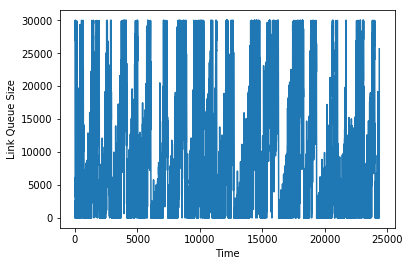

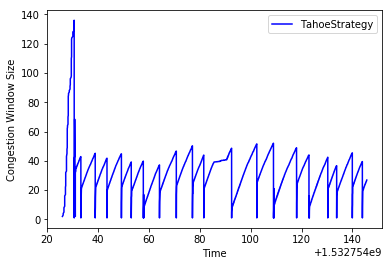

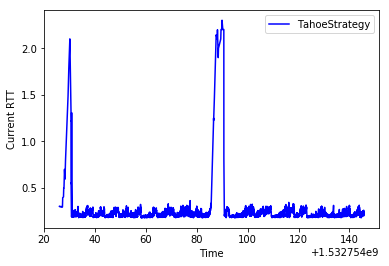

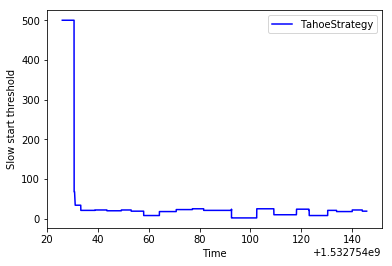

In [9]:
mahimahi_settings = {
    'delay': 88,
    'trace_file': '2.64mbps-poisson.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 30000
    }
}

port = get_open_udp_port()
strat = TahoeStrategy(500, 1)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])

# Low BDP Link -- CUBIC

On this low BDP link, CUBIC still performs a little bit better, albeit with slightly worse RTTs.

* **Throughput:** 14.56kbps
* **Average RTT:** 257.49ms

From looking at these graphs, it looks like with CUBIC we are putting a lot more pressure on the queue, which accounts for the higher average RTTs, as well as the higher throughput. This makes sense--we are no longer dropping the congestion window back down to 0 after a drop--it gets scaled by the beta_cubic constant (which the RFC recommends using 0.7 for).

Also notice that it takes on a cubic shape--it starts by increasing quickly, then tapers off as it gets closer to where the previous drop appeared, and then starts increasing quickly, probing for more bandwidth.



[sender] Connected to receiver: 100.64.0.2:38202

Results for sender 37382, with strategy: CubicStrategy
**Throughput:**                           14562.000000 bytes/s
**Average RTT:**                          257.494033 ms



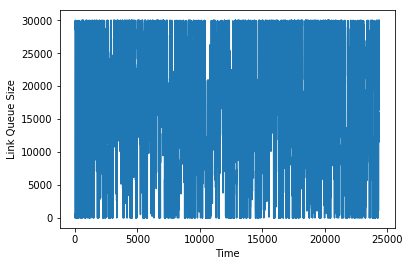

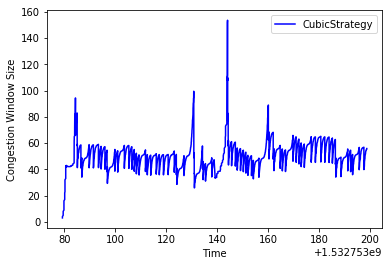

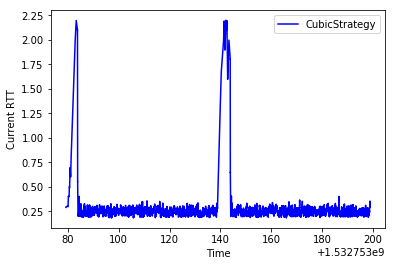

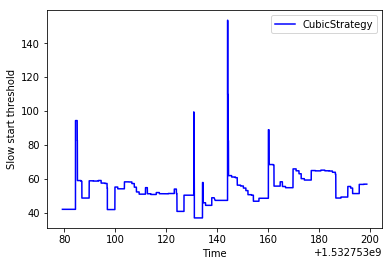

In [2]:
mahimahi_settings = {
    'delay': 88,
    'trace_file': '2.64mbps-poisson.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 30000
    }
}

port = get_open_udp_port()
strat = CubicStrategy(4)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])

# High BDP Link -- Tahoe

This is our baseline for the high bandwidth case. Again, notice that the congestion window gets to about 100 before Tahoe experiences drops and takes pressure off of the queue.

* **Throughput:**  9.54kbps
* **Average RTT:**  431.77ms

[sender] Connected to receiver: 100.64.0.2:53848

Results for sender 58721, with strategy: TahoeStrategy
**Throughput:**                           9541.333333 bytes/s
**Average RTT:**                          439.915105 ms



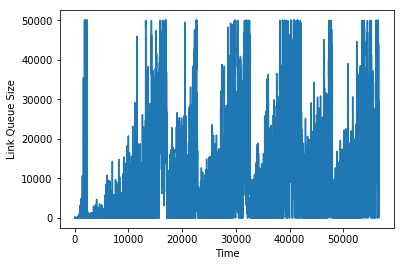

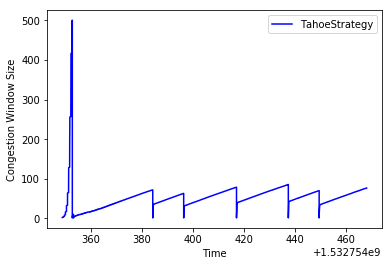

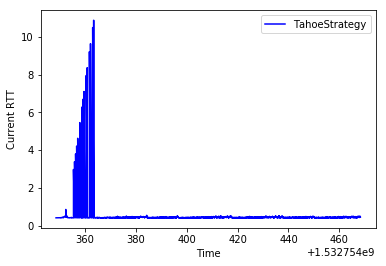

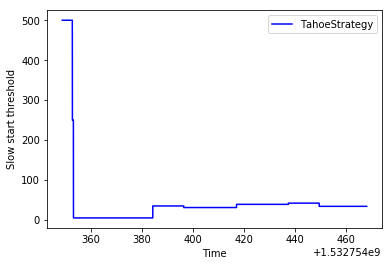

In [10]:
mahimahi_settings = {
    'delay': 200,
    'trace_file': '5.65mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 50000
    }
}

port = get_open_udp_port()
strat = TahoeStrategy(500, 1)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])

# High BDP Link -- CUBIC

Here's where we see where CUBIC really shines: we see a 50% improvement in throughput without much of an increase in RTT. Unlike in Tahoe, during drops, we don't back off nearly as much, and when we do, CUBIC grows the window much faster, therefore taking much more advantage of the available bandwidth.

The graphs of the queue sizes in CUBIC and Tahoe tell a lot of the story--notice that in Tahoe, there is much more time when the queue is empty, which is a leading indicator for underutilization of the bandwidth.


* **Throughput:**  15.13kbps
* **Average RTT:**  441.46ms

[sender] Connected to receiver: 100.64.0.4:43815

Results for sender 48741, with strategy: CubicStrategy
**Throughput:**                           15134.000000 bytes/s
**Average RTT:**                          441.460386 ms



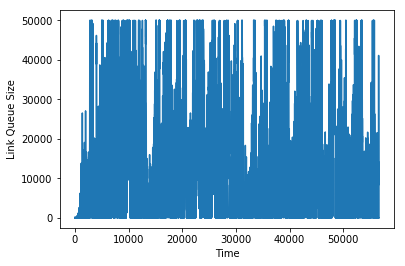

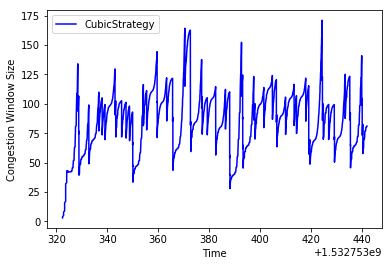

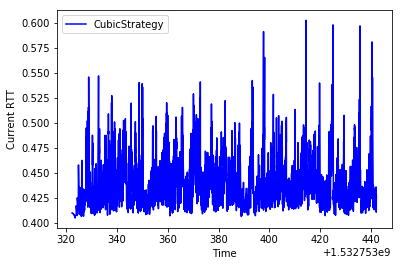

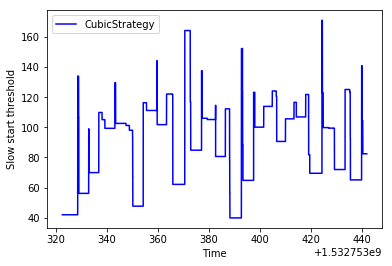

In [4]:
mahimahi_settings = {
    'delay': 200,
    'trace_file': '5.65mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 50000
    }
}

port = get_open_udp_port()
strat = CubicStrategy(4)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port, strat)])

# Fairness - Tahoe vs Tahoe (Low BDP)

The next question is--when Tahoe and CUBIC are placed on the same link, are they fair to each other? In other words, will the CUBIC sender take up a lot more bandwidth than the Tahoe sender?

We start with a baseline of comparing two Tahoe senders. Here, we see that they are pretty fair to each other and achieve pretty much identical throughputs.

Tahoe 1:

* **Throughput:** 10.39kbps
* **Average RTT:** 226.70ms

Tahoe 2:

* **Throughput:** 9.22kbps
* **Average RTT:** 236.70ms


[sender] Connected to receiver: 100.64.0.4:39062

[sender] Connected to receiver: 100.64.0.4:39062

Results for sender 54015, with strategy: TahoeStrategy
**Throughput:**                           10391.333333 bytes/s
**Average RTT:**                          226.701824 ms

Results for sender 35204, with strategy: TahoeStrategy
**Throughput:**                           9221.333333 bytes/s
**Average RTT:**                          236.708869 ms



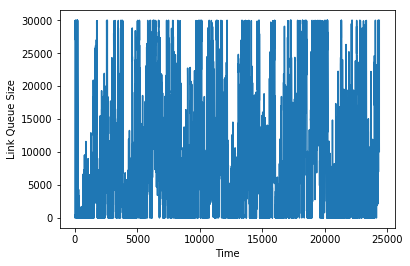

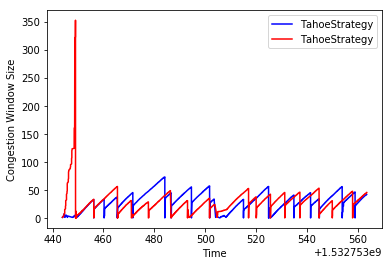

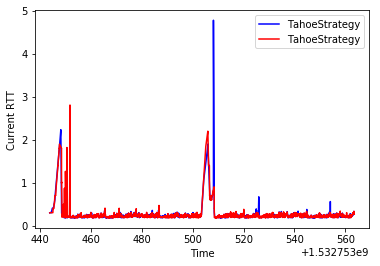

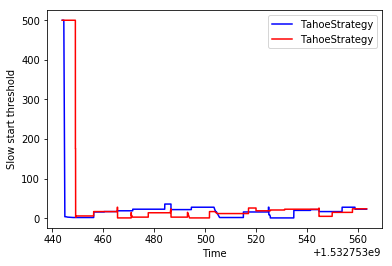

In [5]:
mahimahi_settings = {
    'delay': 88,
    'trace_file': '2.64mbps-poisson.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 30000
    }
}

port1 = get_open_udp_port()
strat1 = TahoeStrategy(500,1)
port2 = get_open_udp_port()
strat2 = TahoeStrategy(500, 1)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port1, strat1), Sender(port2, strat2)])

# Fairness - CUBIC vs. Cubic (High BDP)

A baseline for how CUBIC does when run on the same link as another CUBIC sender. They are very even, and interestingly enough (more detail in the next section) both achieve a higher throughput than a single CUBIC sender running alone.

CUBIC 1:

* **Throughput:** 23.13kbps
* **Average RTT:** 541.57ms

CUBIC 2:

* **Throughput:** 25.01kbps
* **Average RTT:** 523.43ms


[sender] Connected to receiver: 100.64.0.4:42819

[sender] Connected to receiver: 100.64.0.4:42819

Results for sender 46857, with strategy: CubicStrategy
**Throughput:**                           23132.000000 bytes/s
**Average RTT:**                          541.574822 ms

Results for sender 54139, with strategy: CubicStrategy
**Throughput:**                           25010.000000 bytes/s
**Average RTT:**                          523.428253 ms



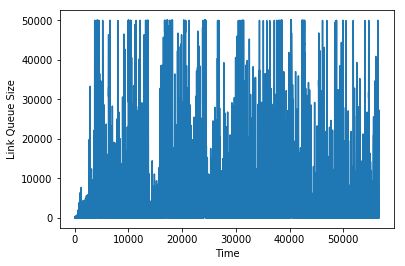

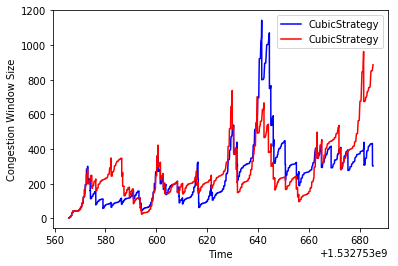

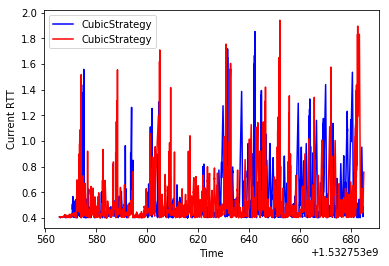

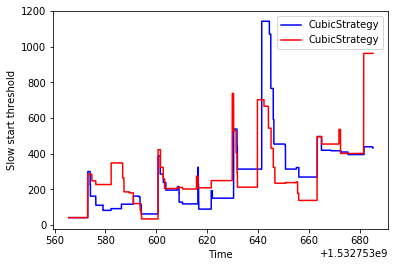

In [6]:
mahimahi_settings = {
    'delay': 200,
    'trace_file': '5.65mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 50000
    }
}

port1 = get_open_udp_port()
strat1 = CubicStrategy(4)
port2 = get_open_udp_port()
strat2 = CubicStrategy(4)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port1, strat1), Sender(port2, strat2)])

# Fairness - CUBIC vs. Tahoe (Low BDP)

Ok, let's now evaluate a CUBIC and a Tahoe sender both running on the same link. The Tahoe sender is definitely sending at a worse bandwidth than it was before, but it's not *terrible*. Overall, the two senders together are achieving a higher throughput than the two Tahoe senders.

This makes sense--since CUBIC is much more aggressive than Tahoe, we expect it to ramp up it's bandwidth usage pretty quickly, especially during times when Tahoe is backing off after a loss.

Tahoe:

* **Throughput:** 6.15kbps
* **Average RTT:** 233.22ms


CUBIC:

* **Throughput:** 17.50kbps
* **Average RTT:** 246.41ms



[sender] Connected to receiver: 100.64.0.6:42084

[sender] Connected to receiver: 100.64.0.6:42084

Results for sender 40196, with strategy: CubicStrategy
**Throughput:**                           17507.333333 bytes/s
**Average RTT:**                          244.830512 ms

Results for sender 51410, with strategy: TahoeStrategy
**Throughput:**                           6152.666667 bytes/s
**Average RTT:**                          234.768885 ms



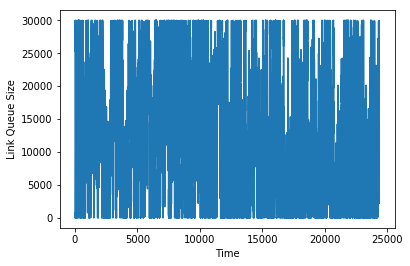

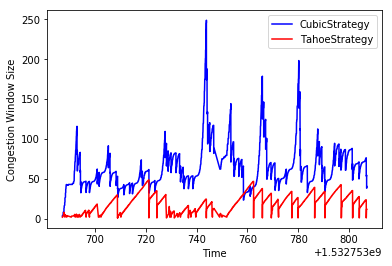

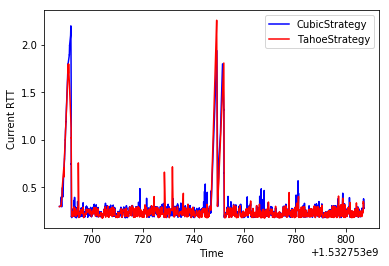

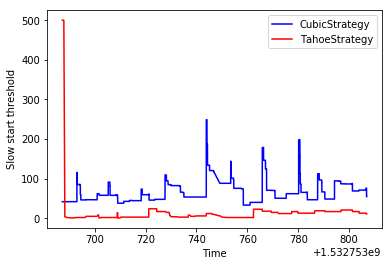

In [7]:
mahimahi_settings = {
    'delay': 88,
    'trace_file': '2.64mbps-poisson.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 30000
    }
}

port1 = get_open_udp_port()
strat1 = CubicStrategy(4)
port2 = get_open_udp_port()
strat2 = TahoeStrategy(500, 1)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port1, strat1), Sender(port2, strat2)])

# Fairness - CUBIC vs. Tahoe (High BDP)

What happens when we dial up the BDP?

Here, the difference between the performance of CUBIC and Tahoe is pretty stark. Also, interestingly, the throughput of the CUBIC sender is way higher here than when it was just running on its own.

This can be understood through the congestion graph--because CUBIC is so aggressive, it sees its first drop much later when it is just running by itself. When it is running alongside Tahoe, it sees its drops earlier because there's another sender jamming up the queue. The earlier drops mean that the slow start threshold ramps up more slowly, and allows CUBIC to achieve higher throughput.

Tahoe:

* **Throughput:** 6.63kbps
* **Average RTT:** 450.38ms

CUBIC:

* **Throughput:** 37.7kbps
* **Average RTT:** 617.06ms

[sender] Connected to receiver: 100.64.0.6:49982

[sender] Connected to receiver: 100.64.0.6:49982

Results for sender 41979, with strategy: CubicStrategy
**Throughput:**                           37704.666667 bytes/s
**Average RTT:**                          617.058459 ms

Results for sender 60151, with strategy: TahoeStrategy
**Throughput:**                           6526.000000 bytes/s
**Average RTT:**                          450.381711 ms



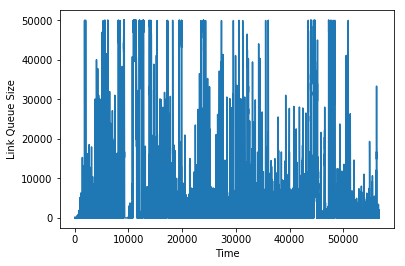

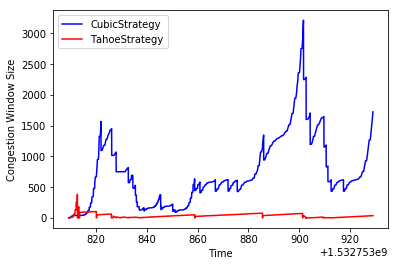

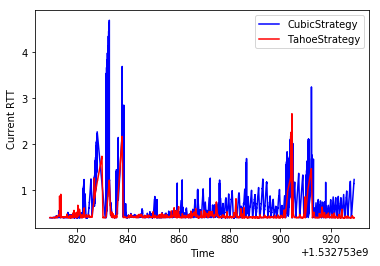

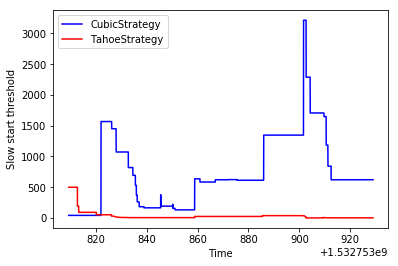

In [8]:
mahimahi_settings = {
    'delay': 200,
    'trace_file': '5.65mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 50000
    }
}

port1 = get_open_udp_port()
strat1 = CubicStrategy(4)
port2 = get_open_udp_port()
strat2 = TahoeStrategy(500, 1)
run_with_mahi_settings(mahimahi_settings, 120, [Sender(port1, strat1), Sender(port2, strat2)])